<a href="https://colab.research.google.com/github/poojamahajan0712/Data-Science-Portfolio/blob/main/Natural%20Language%20Processing/English%20to%20French%20Translator/MachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install "tensorflow-text>=2.11"

<h2> English to French Translation ( Neural Machine Translation with Attention ) </h2>

<h4> Loading required libraries</h4>

In [2]:
import tensorflow as tf
# import tensorflow_text as tf_text
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed, MultiHeadAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Model,load_model, model_from_json

import pickle as pkl
import unicodedata
import re
import pathlib
from collections import Counter
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# setting the working directory
os.chdir('/content/drive/MyDrive/Machine_Translation')

from models.model1 import *
from models.util import *

In [3]:
!rm -rf /content/drive/MyDrive/Machine_Translation/checkpoints/

<h4> Load Data </h4>

In [4]:
dataset_path = "/content/drive/MyDrive/Machine_Translation/eng_-french/eng_-french.csv"
df1 = pd.read_csv(dataset_path)
df1.tail()

,English words/sentences,French words/sentences
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
175620,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [5]:
df1.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [6]:
df1.shape # we have 1.75L sentence pairs

(175621, 2)

In [7]:
eng_text = df1['English words/sentences'].values
french_text = df1['French words/sentences'].values

In [8]:
eng_text[1],french_text[1] ## space before ! is encoded as \u202f

('Run!', 'Cours\u202f!')

Sentence length distribution
* most sentences of length less than 10
* median sentence length is around 6

In [9]:
df1['eng_length'] = df1['English words/sentences'].apply(lambda x : len(x.split(' ')))
df1['french_length'] = df1['French words/sentences'].apply(lambda x : len(x.split(' ')))

In [10]:
df1[['eng_length','french_length']].describe()

,eng_length,french_length
count,175621.00000,175621.000000
mean,6.16145,6.638175
std,2.48559,2.799664
min,1.00000,1.000000
25%,4.00000,5.000000
50%,6.00000,6.000000
75%,7.00000,8.000000
max,44.00000,55.000000


<Axes: >

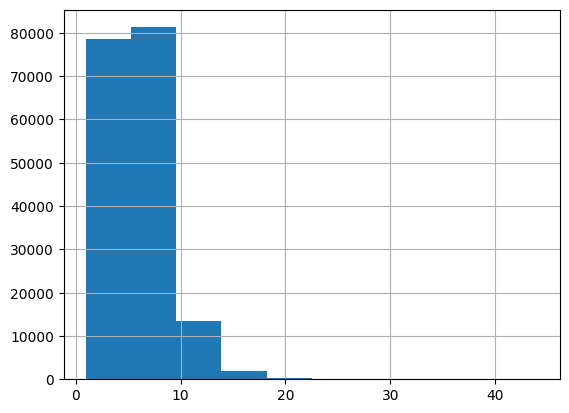

In [11]:
df1['eng_length'].hist()

In [12]:
df1[df1['eng_length']==df1['eng_length'].max()]

,English words/sentences,French words/sentences,eng_length,french_length
175620,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...,44,55


In [13]:
df1['len_ratio'] = df1['eng_length']/df1['french_length']
df1['len_ratio'].describe()
## on average it is 1:1 ratio for english to french translation

,len_ratio
count,175621.000000
mean,0.969825
std,0.284823
min,0.200000
25%,0.800000
50%,1.000000
75%,1.000000
max,10.000000


<h4> Data Preprocessing </h4>

In [14]:
eng_processed = [lower_and_split_punct(sentence) for sentence in eng_text]
french_processed = [lower_and_split_punct(sentence) for sentence in french_text]

In [15]:
eng_processed[0],eng_text[0],french_processed[0],french_text[0]


('[START] hi . [END]', 'Hi.', '[START] salut ! [END]', 'Salut!')

<h4> Data Preparation for Model Building </h4>

In [16]:
X = eng_processed
Y = french_processed
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(158058, 158058, 17563, 17563)

In [17]:
X_train[0], y_train[0]

('[START] no criminal charges will be filed against you . [END]',
 '[START] aucune charge ne sera retenue contre vous . [END]')

In [18]:
#Training data
max_length_english = Max_length(X_train)
max_length_french= Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_french_test = Max_length(y_test)

In [19]:
max_length_english,max_length_french,max_length_english_test,max_length_french_test

(53, 64, 38, 39)

In [21]:
df1.head()

,English words/sentences,French words/sentences,eng_length,french_length,len_ratio
0,Hi.,Salut!,1,1,1.0
1,Run!,Cours !,1,1,1.0
2,Run!,Courez !,1,1,1.0
3,Who?,Qui ?,1,2,0.5
4,Wow!,Ça alors !,1,2,0.5


In [22]:
## Creating english tokeniser and padding the sequences upto maxlength
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

In [23]:
## Creating French tokeniser and padding the sequences upto maxlength
frenchTokenizer = Tokenizer()
frenchTokenizer.fit_on_texts(y_train)
Fword2index = frenchTokenizer.word_index
vocab_size_target = len(Fword2index) + 1

y_train = frenchTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_french, padding='post')

y_test = frenchTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_french_test, padding='post')

VocabSize and Maxlength for each sentence

In [47]:
max_length_english,max_length_french,max_length_english_test,max_length_french_test

(53, 64, 38, 39)

In [25]:
vocab_size_source,vocab_size_target

(13945, 26908)

In [26]:
# # saving for future use

# with open('data_pkl/NMT_data.pkl','wb') as f:
#   pkl.dump([X_train, y_train, X_test, y_test],f)

# with open('data_pkl/NMT_Etokenizer.pkl','wb') as f:
#   pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

# with open('data_pkl/NMT_Ftokenizer.pkl', 'wb') as f:
#   pkl.dump([vocab_size_target, Fword2index, frenchTokenizer], f)

In [27]:
## lets view the transformed data
X_train[0], y_train[0]

(array([   1,   58, 1911, 2344,   61,   28, 3662,  501,    4,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([   1,  316, 1878,    9,  290, 6344,  468,   11,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [28]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [29]:
y_train.shape

(158058, 64)

In [30]:
vocab_size_source,vocab_size_target, max_length_english, max_length_french

(13945, 26908, 53, 64)

<h4> Model Building </h4>

In [31]:
# latent_dim = 200 for next run
latent_dim = 150
model = translation_model(max_length_english,vocab_size_source,vocab_size_target,latent_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        697,250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 150),      │        120,600 │ embedding[0][0]        │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 150),      │        180,600 │ lstm[0][0]             │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 150),      │        180,600 │ lstm_1[0][0]           │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 150),    │        120,600 │ embedding_1[0][0],     │
│                           │ (None, 150), (None,    │                │ lstm_2[0][1],          │
│                           │ 150)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 150),    │        723,750 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 300)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26908)    │      8,099,308 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,468,108 (43.75 MB)

 Trainable params: 11,468,108 (43.75 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# for idx, layer in enumerate(model.layers):
#     print(f"Layer index: {idx}, Layer name: {layer.name}, Layer type: {type(layer)}"

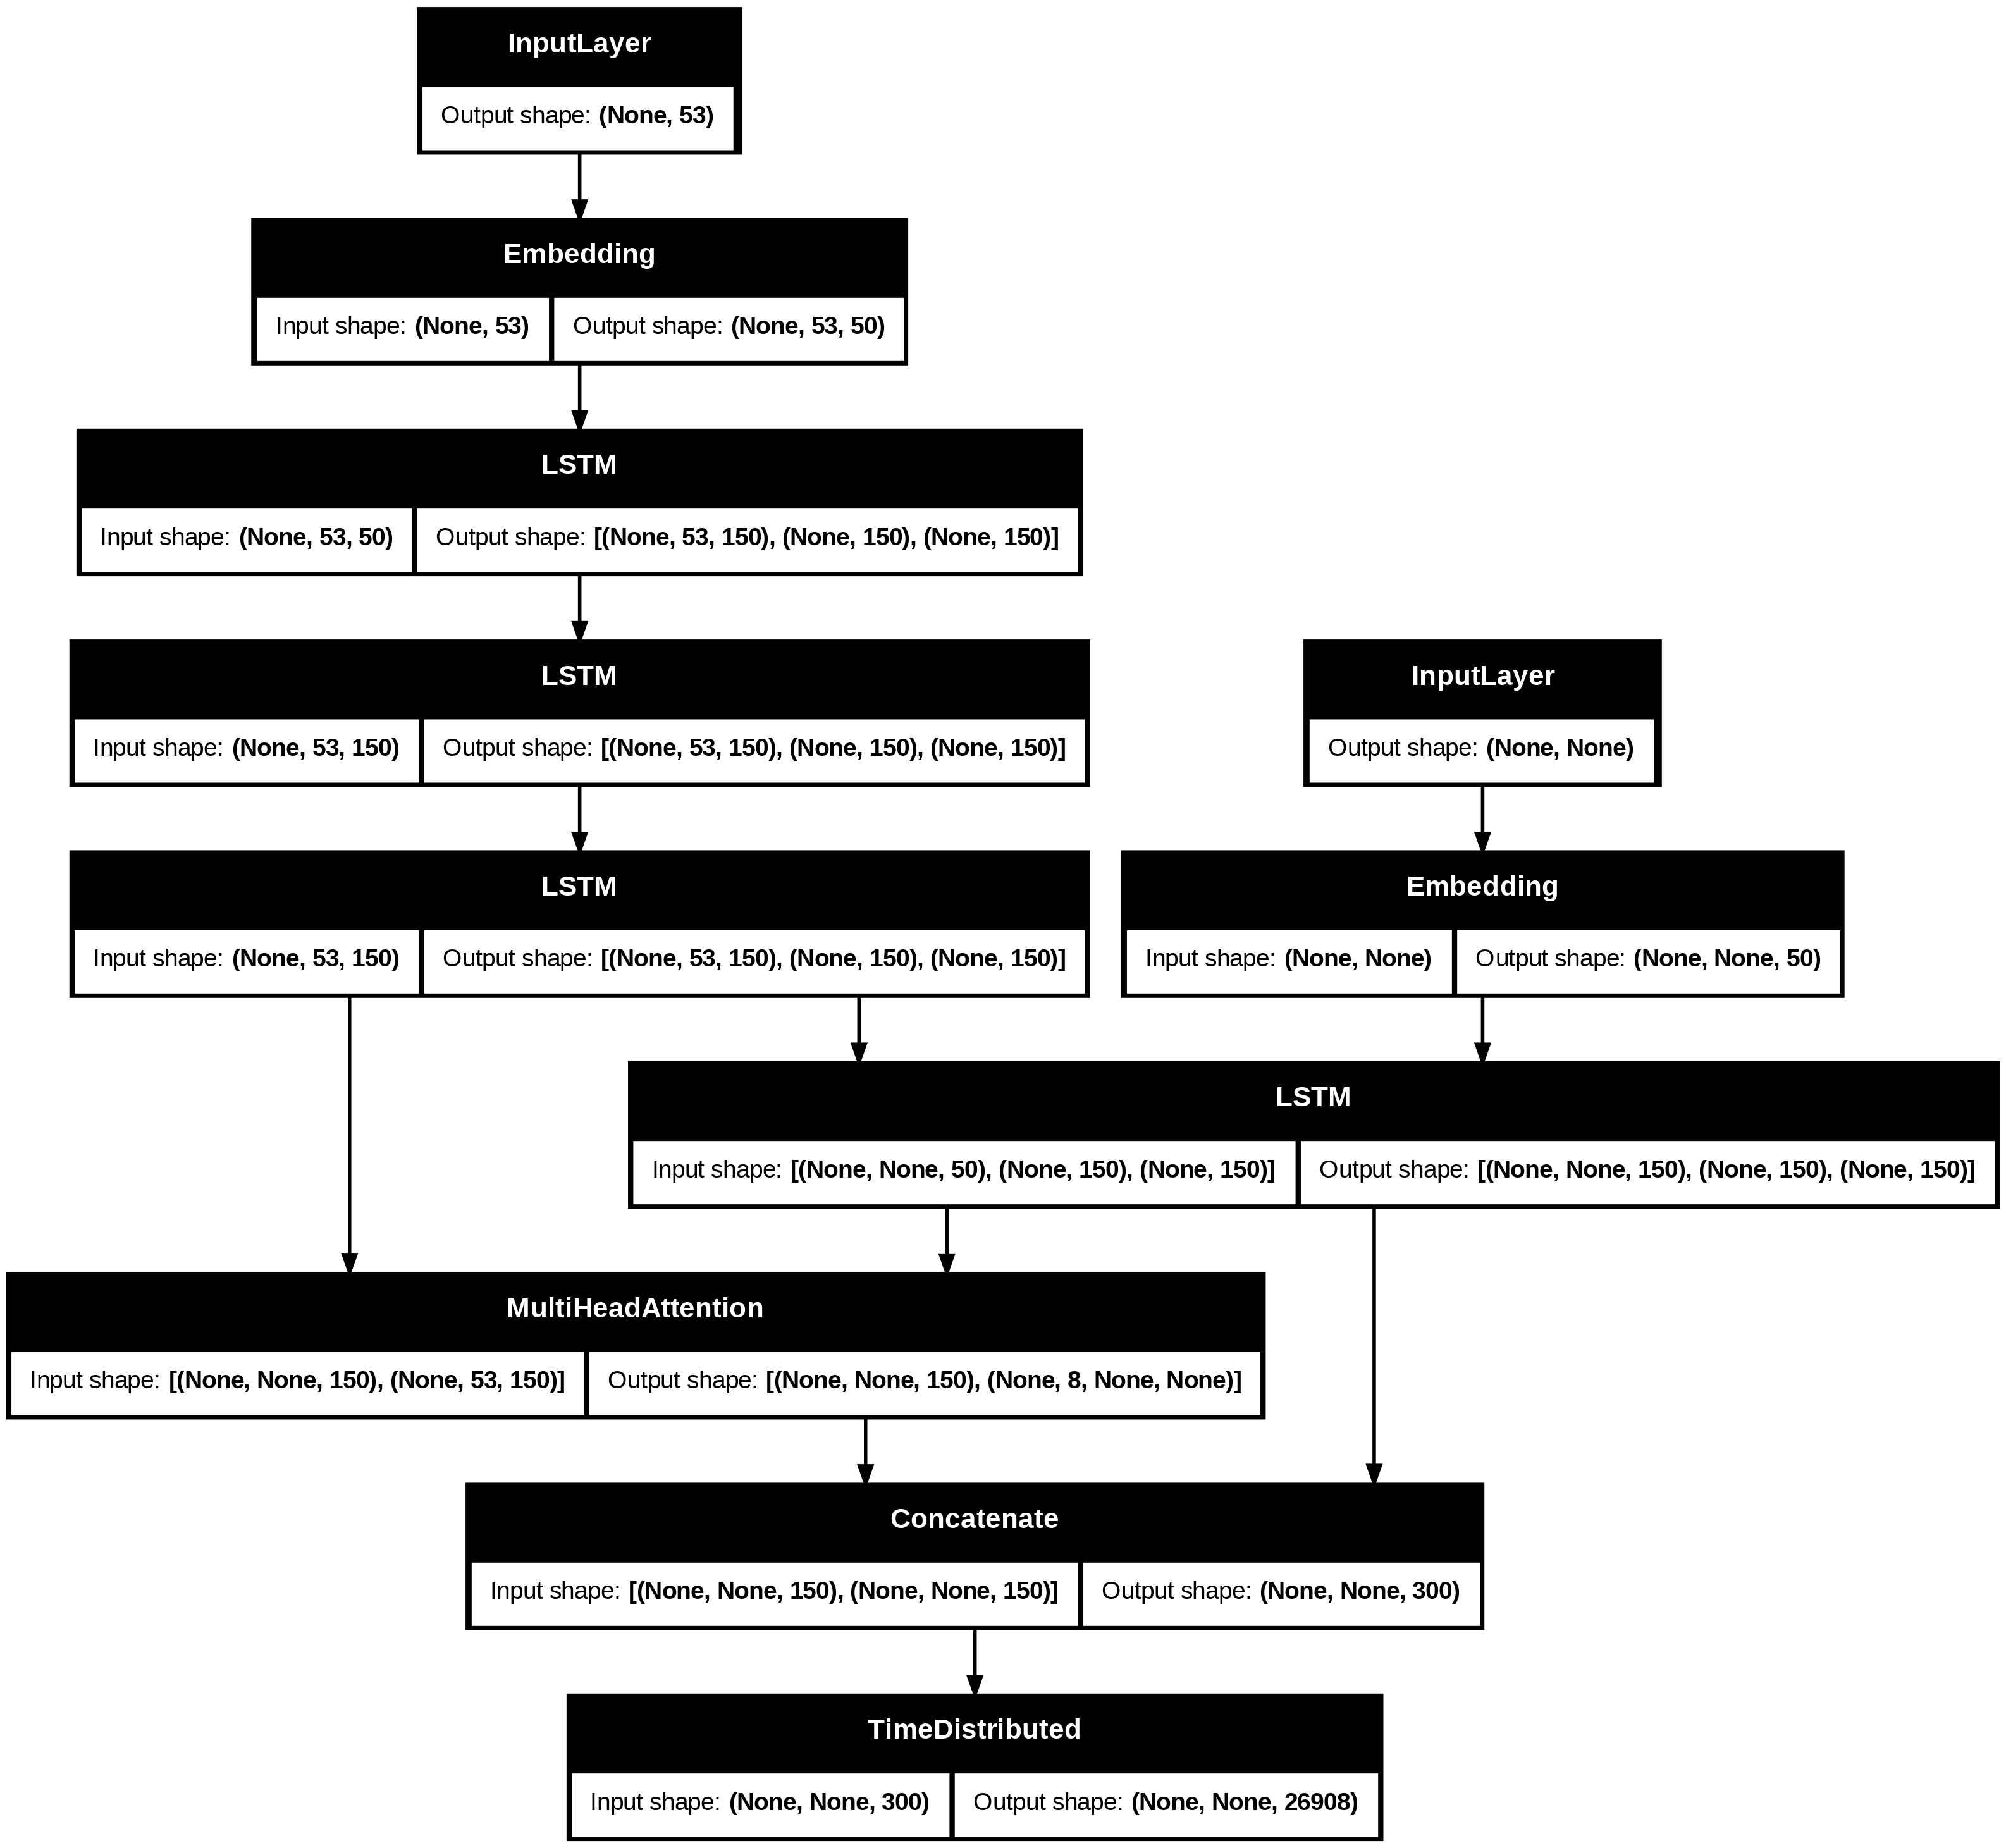

In [33]:
model_id = 1
plot_model(model, to_file=f'saved_model/model_id={model_id}/train_model1.png', show_shapes=True)

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
# callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [36]:
# # Define a checkpoint callback
checkpoint_filepath_to_check = '/content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_{epoch:02d}.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_to_check,
    save_weights_only=True,
    save_best_only=False,
    monitor='loss',
    verbose=1
)
# epoch_to_load = 8
#checkpoint_filepath_to_check = '/content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_08.weights.h5'
# Check if the checkpoint file exists before loading
if os.path.exists(checkpoint_filepath_to_check):
    model.load_weights(checkpoint_filepath_to_check)
    print(f"Checkpoint loaded from {checkpoint_filepath_to_check}. Resuming training from epoch {epoch_to_load}...")
else:
    print(f"No checkpoint found at {checkpoint_filepath_to_check}. Starting training from scratch.")


No checkpoint found at /content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_{epoch:02d}.weights.h5. Starting training from scratch.


In [37]:
# Teacher Forcing technique
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=7,
                    callbacks=[es,checkpoint_callback],
                    batch_size=128,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/7
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8906 - loss: 1.0902
Epoch 1: saving model to /content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_01.weights.h5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 539s 425ms/step - accuracy: 0.8906 - loss: 1.0899 - val_accuracy: 0.8418 - val_loss: 1.0915
Epoch 2/7
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9042 - loss: 0.6605
Epoch 2: saving model to /content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_02.weights.h5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 561s 430ms/step - accuracy: 0.9042 - loss: 0.6605 - val_accuracy: 0.8455 - val_loss: 1.0247
Epoch 3/7
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9074 - loss: 0.6178
Epoch 3: saving model to /content/drive/MyDrive/Machine_Translation/checkpoints/checkpoint.epoch_03.weights.h5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 563s 430ms/step - accuracy: 0.9074 - loss: 0.6178 - val_accuracy: 0.8515 - val_loss: 0.9588
Epoch 4/7
1235/1235 ━━━━━━━━━━━

In [38]:
# save model

base_path = f"/content/drive/MyDrive/Machine_Translation/saved_model/model_id={model_id}/"
model_name = f"NMT_model{model_id}.json"
model_weights = f"NMT_model_weight{model_id}.weights.h5"
model_json = model.to_json()
with open(base_path+model_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(base_path+model_weights)
print("Saved model to disk")

Saved model to disk


In [39]:
# loading the model architecture and asigning the weights
json_file = open(base_path+model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights(base_path+model_weights)

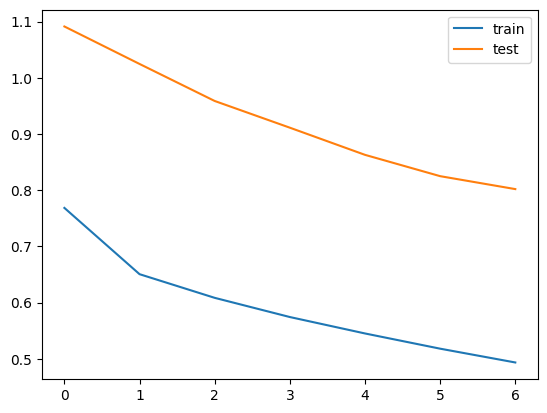

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:

with open('data_pkl/NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('data_pkl/NMT_Ftokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, marathiTokenizer = pkl.load(f)

with open('data_pkl/NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [43]:
Eindex2word = englishTokenizer.index_word
Findex2word = frenchTokenizer.index_word

In [44]:
model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        697,250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 150),      │        120,600 │ embedding[0][0]        │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 150),      │        180,600 │ lstm[0][0]             │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 150),      │        180,600 │ lstm_1[0][0]           │
│                           │ (None, 150), (None,    │                │                        │
│                           │ 150)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 150),    │        120,600 │ embedding_1[0][0],     │
│                           │ (None, 150), (None,    │                │ lstm_2[0][1],          │
│                           │ 150)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 150),    │        723,750 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 300)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26908)    │      8,099,308 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,936,218 (87.49 MB)

 Trainable params: 11,468,108 (43.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,468,110 (43.75 MB)

In [48]:

encoder_model, decoder_model = decoder_inference(model_loaded,latent_dim,max_length_english)

(None, 53, 150)
(None, None)


In [50]:
for i in range(10):
  print("Review:",source_sequence(X_test[i],Eindex2word))
  print("Original summary:",target_sequence(y_test[i],Fword2index,Findex2word))
  print("Predicted summary:",decode_sequence(encoder_model,Fword2index,decoder_model,X_test[i].reshape(1,max_length_english),Findex2word))
  print("\n")

Review: start my wife is a good manager end 
Original summary: ma femme est un bon 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted summary:  mon pere est un peu de temps


Review: start he wears a bow tie every day end 
Original summary: il porte un nud papillon au quotidien 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/s

This approach uses encoder decoder architecture with attention as a base approach and further training for more epochs coupled with increasing the parameters will lead to improvement in accuracy.<br>
 Further we can make use of other state of the art model architectures like Transformers to enhance the accuracy of the model.
